In [1]:
import pandas as pd
import MultiContagion as mc
import igraph
import random
import numpy as np
from matplotlib import pylab as plt
import scipy.stats
import copy
#import powerlaw
%matplotlib inline

In [2]:
df = pd.read_stata("normalized.dta")
df = df.sort_index(by=['country'])
#by argument to sort_index is deprecated, pls use .sort_values(by=...)
df = df.fillna(value = 0.)

/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


In [3]:
df;

In [4]:
df_inflation = pd.read_csv("USA-PCPIE.csv", index_col="Year")

In [5]:
df_inflation = df_inflation.multiply(1000)

**Note on unities, inflation is in billion dollars and surveys are in million dollars **

[1] "Country Name"                                                                    
 [2] "Country Code"                                                                    
 [3] "Counterpart Country Name"                                                        
 [4] "Counterpart Country Code"                                                        
 [5] "Time Period"                                                                     
 [6] "IIP Equity investment asset, millions of USD"                                    
 [7] "IIP Debt instrument asset, millions of USD"                                      
 [8] "IIP Direct investment asset, millions of USD"                                    
 [9] "IIP Direct investment asset between fellow enterprise, millions of USD"          
[10] "IIP Total Portfolio invertment, Assets, millions of USD"                         
[11] "IIP Portfolio invertment,Equity and investment fund shares, Assets, millions of "

[12] "IIP Portfolio invertment,Debt securities, Assets, millions of USD"               
[13] "BIS loans and deposit claims positions, USD" <\br>

layers should be: 6, 7, 11, 12 and 13

In [8]:
df;

# CDIS Equity Layer

## The contagion network

In [6]:
def make_cont_net_from_survey_year_no_isolated(df, data, year):
    country = df["country"][ (df[data].notnull()) & (df[data] > 0 ) & (df["year"] == year )]
    countercountry = df["counterpart"][ (df[data].notnull()) & (df[data] > 0 ) & (df["year"] == year)  ]
    survey = df[data][ (df[data].notnull()) & (df[data] > 0 ) & (df["year"] == year) ]
    edges, weight = mc.make_edge_list(countercountry,country, survey)
    G = mc.make_graph_from_edge(edges, weight)
    return G

In [7]:
Year = 2015

In [8]:
def make_graphs(y):
    """graphs with no isolated countries, but then dimensions between matrices dont match"""
    G_cd_equity_15 = make_cont_net_from_survey_year_no_isolated(df, "CDIS_IADE", y)
    G_cd_debt_15 = make_cont_net_from_survey_year_no_isolated(df, "CDIS_IADD", y)
    G_cp_equity_15 = make_cont_net_from_survey_year_no_isolated(df, "CPIS_IAPE", y)
    G_cp_debt_15 = make_cont_net_from_survey_year_no_isolated(df, "CPIS_IAPD", y)
    G_bis_15 = make_cont_net_from_survey_year_no_isolated(df, "loans_dep", y)
    G_15_list = [G_cd_equity_15, G_cd_debt_15, G_cp_equity_15, G_cp_debt_15, G_bis_15  ]
    G_names = ["CDIS_equity", "CDIS_debt", "CPIS_equity", "CPIS_debt", "BIS" ]
    G_adjacency_15 = []
    
    for g in G_15_list:
        G_adjacency_15.append(np.array((g.get_adjacency(attribute= "weight")).data))
    
    return G_15_list, G_names, G_adjacency_15#, G_agg_2015

In [9]:
def make_agg_graph_local(y):
    G_cd_equity_15 = mc.make_cont_net_from_survey_year(df, "CDIS_IADE", y)
    G_cd_debt_15 = mc.make_cont_net_from_survey_year(df, "CDIS_IADD", y)
    G_cp_equity_15 = mc.make_cont_net_from_survey_year(df, "CPIS_IAPE",y)
    G_cp_debt_15 = mc.make_cont_net_from_survey_year(df, "CPIS_IAPD", y)
    G_bis_15 = mc.make_cont_net_from_survey_year(df, "loans_dep", y)
    G_15_list = [G_cd_equity_15, G_cd_debt_15, G_cp_equity_15, G_cp_debt_15, G_bis_15  ]
    G_adjacency_15 = []
    for g in G_15_list:
        G_adjacency_15.append(np.array((g.get_adjacency(attribute= "weight")).data))

    AM_agg_2015 = G_adjacency_15[0] + G_adjacency_15[1] + G_adjacency_15[2] + G_adjacency_15[3] + G_adjacency_15[4]
    G_agg_2015 = igraph.Graph.Weighted_Adjacency(AM_agg_2015.tolist(), attr= "weight")
    
    return G_agg_2015, AM_agg_2015

In [10]:
G_list, G_nm, G_adj = make_graphs(Year)
G_agg, G_adj_agg = make_agg_graph_local(Year)

In [11]:
len(G_adj[2][0]) # we excluded some nodes
len( G_adj_agg), len(G_adj_agg[0])

(212, 212)

In [12]:
dict_survey_names = {0: "CDIS-equity", 1: "CDIS-debt",2: "CPIS-equity",3: "CPIS-debt",4: "BIS"}

In [20]:
name = "AM4_no_isolated-OutFlow"
for y in range(2008,2016):
    G_list, G_nm, G_adj = make_graphs(y)
    for i in range(5):
        survey_name = dict_survey_names[i]
        np.savetxt("csv_files/"+name+survey_name+str(y)+".csv", G_adj[i], delimiter=",")

In [21]:
my_data2 = np.genfromtxt('csv_files/AM4_no_isolatedCDIS-equity2015.csv', delimiter=',')

In [22]:
G_adj[0] == my_data2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

### Save basic measurments

In [23]:
def save_basic_measurements(y, G_list_plus_agg, G_nm_plus_agg):
    f = open("csv_files/basic_masurements_"+str(Year) +".csv", "w")
    f.write(",diameter,density,average path length,global clustering,average clustering (unweighted),average clustering,sum of weights\n")
    n = len(G_nm_plus_agg)
    for i in range(n):
        f.write(G_nm_plus_agg[i] + ",")
        g = G_list_plus_agg[i]
        weights = np.array(copy.deepcopy(g.es["weight"]))
        f.write(str( round(g.diameter(), 2) ) + ",")
        f.write(str( round(g.density(), 2) ) + ",")
        f.write(str( round(g.average_path_length(), 2) ) + ",")
        f.write(str( round(g.transitivity_undirected(), 2) ) + ",")
        f.write(str( round(np.mean(g.transitivity_local_undirected( mode = "zero")), 2) ) + ",")
        f.write(str( round(np.mean(g.transitivity_local_undirected(weights = g.es["weight"],  mode = "zero" )), 2) ) + ",")
        f.write(str( round(sum(weights)) ) + "\n")
    f.close()

In [35]:
for Year in [2008 + i for i in range(8)]:
    print Year
    G_list, G_nm, G_adj = make_graphs(Year)
    G_agg = make_agg_graph_local(Year)
    G_list_plus_agg = G_list + [G_agg]
    G_nm_plus_agg = G_nm + ["Aggregated"]
    save_basic_measurements(Year, G_list_plus_agg, G_nm_plus_agg)

2008
2009
2010
2011
2012
2013
2014
2015


### Distance between networks of different years

### we need matrices with all the nodes, even the ones that were not reported in that year

In [13]:
Year = 2015

In [14]:
df = pd.read_stata("normalized.dta")
df = df.sort_index(by=['country'])
df = df.fillna(value = 0.)

/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


In [15]:
df;

In [16]:
def make_cont_net_from_survey_year_all_countries(df, data, year):
    all_years = [i for i in range(2008,2016)]
    all_years.remove(year)
    #print all_years
    country = df["country"]
    countercountry = df["counterpart"]
    DF = df.copy()
    DF.ix[df.year.isin(all_years), data] = 0
    survey = DF[data]
    edges, weight = mc.make_edge_list(countercountry,country, survey)
    for i in range(len(weight)):
        if weight[i] < 0:
            weight[i] = 0
    G = mc.make_graph_from_edge(edges, weight)
   
    return G


In [17]:
def make_graphs_allnodes(y, norm = False):
    '''Dimensions of matrices match even between years'''
    df_copy = copy.deepcopy(df)
    if norm == True:
        df_copy[['CDIS_IADE', 'CDIS_IADE', 'CPIS_IAPE', 'CPIS_IAPD', 'loans_dep' ] ] *= 1./df_inflation["Inflation"][y]
    G_cd_equity_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CDIS_IADE", y)
    G_cd_debt_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CDIS_IADD", y)
    G_cp_equity_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CPIS_IAPE", y)
    G_cp_debt_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CPIS_IAPD", y)
    G_bis_15 = make_cont_net_from_survey_year_all_countries(df_copy, "loans_dep", y)
    G_15_list = [G_cd_equity_15, G_cd_debt_15, G_cp_equity_15, G_cp_debt_15, G_bis_15  ]
    G_names = ["CDIS_equity", "CDIS_debt", "CPIS_equity", "CPIS_debt", "BIS" ]
    G_adjacency_15 = []
    
    for g in G_15_list:
        G_adjacency_15.append(np.array((g.get_adjacency(attribute= "weight")).data))
    #print G_15_list[0].vs["name"][0]
    return G_15_list, G_names, G_adjacency_15#, G_agg_2015

In [18]:
def make_agg_graph(y, norm = False):
    df_copy = copy.deepcopy(df)
    if norm == True:
        df_copy[['CDIS_IADE', 'CDIS_IADE', 'CPIS_IAPE', 'CPIS_IAPD', 'loans_dep' ] ] *= 1./df_inflation["Inflation"][y]
    G_cd_equity_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CDIS_IADE", y)
    G_cd_debt_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CDIS_IADD", y)
    G_cp_equity_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CPIS_IAPE",y)
    G_cp_debt_15 = make_cont_net_from_survey_year_all_countries(df_copy, "CPIS_IAPD", y)
    G_bis_15 = make_cont_net_from_survey_year_all_countries(df_copy, "loans_dep", y)
    G_15_list = [G_cd_equity_15, G_cd_debt_15, G_cp_equity_15, G_cp_debt_15, G_bis_15  ]
    G_adjacency_15 = []
    for g in G_15_list:
        G_adjacency_15.append(np.array((g.get_adjacency(attribute= "weight")).data))

    AM_agg_2015 = G_adjacency_15[0] + G_adjacency_15[1] + G_adjacency_15[2] + G_adjacency_15[3] + G_adjacency_15[4]
    G_agg_2015 = igraph.Graph.Weighted_Adjacency(AM_agg_2015.tolist(), attr= "weight")
    
    return G_agg_2015, AM_agg_2015

In [19]:
dict_survey_names = {0: "CDIS-equity", 1: "CDIS-debt",2: "CPIS-equity",3: "CPIS-debt",4: "BIS"}

In [20]:
name = "AM4_all_nodesNormOutFlow"
for y in range(2008,2016):
    G_list, G_nm, G_adj = make_graphs_allnodes(y, norm = True)
    for i in range(5):
        survey_name = dict_survey_names[i]
        np.savetxt("csv_files/"+name+survey_name+str(y)+".csv", G_adj[i], delimiter=",")

In [21]:
name = "AM4_all_nodes_aggregateNormOutFlow"
for y in range(2008,2016):
    Ga_list, G_adj = make_agg_graph(y, norm = True)
    np.savetxt("csv_files/"+name+str(y)+".csv", G_adj, delimiter=",")

In [22]:
all_names = G_list[0].vs["name"]

In [23]:
len( G_list[3].vs["name"])

213

In [24]:
len(all_names)

213

In [43]:
all_names = G_list[0].vs["name"]
#f = open("csv_files/"+"all_country_name4"+".csv", "w")
for i in all_names:
    f.write(i+"\n")
f.close()

### HeatMap

#### For aggregated network

In [250]:
G_Ag_ADJ = []
G_Ag_NAMES = []
G_Ag_G = []
for y in range(2008,2016):
    a, c = make_agg_graph(y,norm = True)
    G_Ag_ADJ.append(c)

In [251]:
def norm_matrix(A):
    norm = sum(sum(A))
    #print norm
    return A/norm

In [252]:
len(G_Ag_ADJ)#[2] #== G_ADJ[2][2]

8

In [255]:
A_agg_NORM = []
for am in G_Ag_ADJ:
    A_agg_NORM.append(norm_matrix(am) )

In [256]:
mean_agg, std_agg = np.mean(difference_single_mat(A_agg_NORM[0] , A_agg_NORM[1])), np.std(difference_single_mat(A_agg_NORM[0] , A_agg_NORM[1]))

In [257]:
test = difference_single_mat(A_agg_NORM[0] , A_agg_NORM[1])

In [258]:
t = filter(lambda a: a != 0, test)

In [259]:
np.mean(t), np.std(t)

(8.6195521774940363e-05, 0.00076599636529597187)

In [260]:
mean_agg, std_agg

(1.808852071426305e-05, 0.00035265307454740284)

In [261]:
mean_agg, std_agg = np.mean(difference_mat(A_NORM[0][1] , A_NORM[1][1])), np.std(difference_mat(A_NORM[0][1] , A_NORM[1][1]))

In [262]:
mean_agg, std_agg

(3.529193550768448e-05, 0.0027076999505404992)

In [209]:
difference_single_mat(A_agg_NORM[-2] , A_agg_NORM[-1])[11] #== difference_mat(A_NORM[0][1] , A_NORM[1][1])

4.4369767471320872e-77

In [195]:
def difference_mat(A, B):
    l = len(A[0])
    dif = []
    for i in range(l):
        for j in range(l):
            dif.append( abs( A[i, j] - B[i, j]))
    return dif

In [211]:
difference_mat(A_NORM[-2][0] , A_NORM[0][0])[11]

0.0

In [212]:
difference_mat(A_NORM[-2][1] , A_NORM[0][1])[11]

0.0

In [213]:
difference_mat(A_NORM[-2][2] , A_NORM[0][2])[11]

0.0

In [214]:
difference_mat(A_NORM[-2][3] , A_NORM[0][3])[11]

0.0

In [208]:
difference_mat(A_NORM[-2][-1] , A_NORM[-1][-1])[11]

2.0231447139935628e-08

In [167]:
difference_mat(A_NORM[0][1] , A_NORM[1][1])

1.9990763948972874

In [168]:
difference_mat(A_NORM[0][0] , A_NORM[1][0])

1.9712601208704674

In [185]:
difference_single_mat(A_agg_NORM[0] , A_agg_NORM[1])

1.9990763948972874

In [189]:
A_agg_NORM[1][-2,-1]

6.7324239189222657e-63

In [188]:
A_NORM[1][1][-2,-1]

0.0

In [263]:
def difference_single_mat(A, B):
    l = len(A)
    dif = []
    for i in range(l):
        for j in range(l):
            dif.append(abs( A[i, j] - B[i, j]))
    return dif

In [265]:
dif = []
for y1 in range(2016-2009):
    dif.append([])
    for y2 in range(2016-2009):
        dif[y1].append(sum(difference_single_mat(A_agg_NORM[y1 + 1] , A_agg_NORM[y2 + 1])))
    

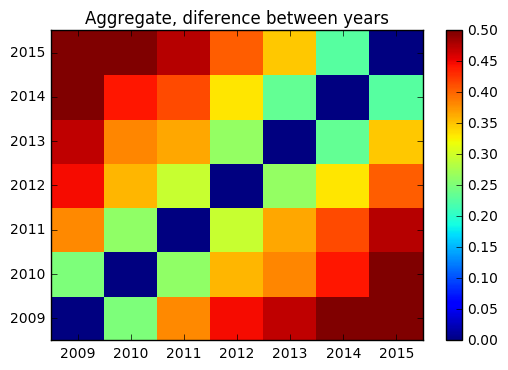

In [266]:
fig, ax = plt.subplots()
labels = [str(y) for y in range(2009,2016)]#'abcdefghij'

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)

plt.pcolor(dif,  vmin=0, vmax=0.5)
plt.title("Aggregate, diference between years")
plt.colorbar()
plt.savefig("fig/TemporalDiferenceNorm-Agg-eq.png")

In [153]:
dif == DIF[1]

True

### All

In [269]:
G_ADJ = []
G_NAMES = []
G_G = []
for y in range(2008,2016):
    a, b , c = make_graphs_allnodes(y)
    G_ADJ.append(c )

In [270]:
A_NORM = []
for g_year in G_ADJ:
    A_NORM.append([norm_matrix(am) for am in g_year])

In [271]:
def difference_mat(A, B):
    l = len(A[0])
    dif = 0
    for i in range(l):
        for j in range(l):
            dif += abs( A[i, j] - B[i, j])
    return dif

In [272]:
difference_mat(A_NORM[-1][2] , A_NORM[-2][2])

0.16437326430905136

In [273]:
DIF = []
for i in range(5):
    dif = []
    for y1 in range(2016-2009):
        dif.append([])
        for y2 in range(2016-2009):
            dif[y1].append(difference_mat(A_NORM[y1 + 1][i] , A_NORM[y2 + 1][i]))
    DIF.append(dif)

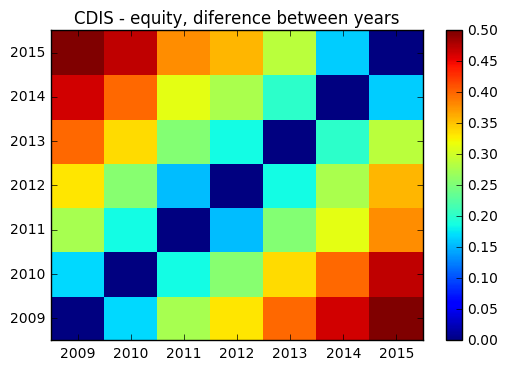

In [274]:
fig, ax = plt.subplots()
labels = [str(y) for y in range(2009,2016)]#'abcdefghij'

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)

plt.pcolor(DIF[0],  vmin=0, vmax=0.5)
plt.title("CDIS - equity, diference between years")
plt.colorbar()
#plt.savefig("fig/TemporalDiferenceNorm-CDIS-eq.png")

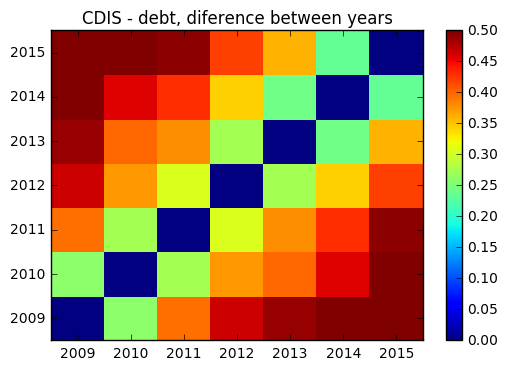

In [163]:
fig, ax = plt.subplots()
labels = [str(y) for y in range(2009,2016)]#'abcdefghij'

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)

plt.pcolor(DIF[1],  vmin=0, vmax=0.5)
plt.savefig("fig/TemporalDiference-CDIS-de.png")
plt.title("CDIS - debt, diference between years")
plt.colorbar()
#plt.savefig("fig/TemporalDiferenceNorm-CDIS-de.png")

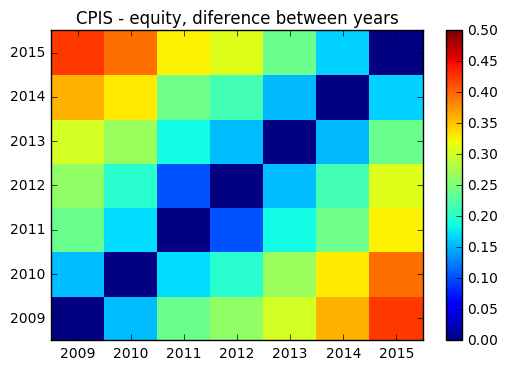

In [89]:
fig, ax = plt.subplots()
labels = [str(y) for y in range(2009,2016)]#'abcdefghij'

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)

plt.pcolor(DIF[2],  vmin=0, vmax=0.5)
plt.title("CPIS - equity, diference between years")
plt.colorbar()
plt.savefig("fig/TemporalDiferenceNorm-CPIS-eq.png")

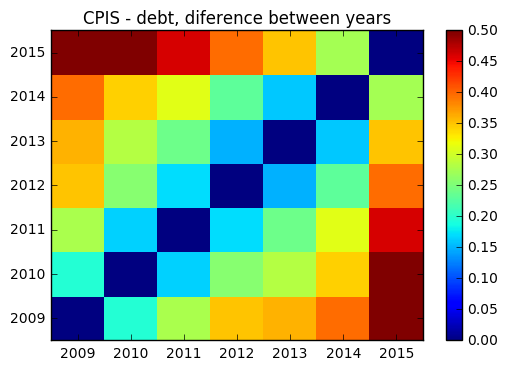

In [90]:
fig, ax = plt.subplots()
labels = [str(y) for y in range(2009,2016)]#'abcdefghij'

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)

plt.pcolor(DIF[3],  vmin=0, vmax=0.5)
plt.title("CPIS - debt, diference between years")
plt.colorbar()
plt.savefig("fig/TemporalDiferenceNorm-CPIS-de.png")

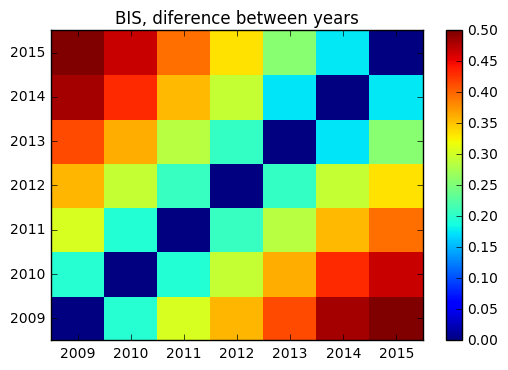

In [79]:
fig, ax = plt.subplots()
labels = [str(y) for y in range(2009,2016)]#'abcdefghij'

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)

plt.pcolor(DIF[4],  vmin=0, vmax=0.5)
plt.title("BIS, diference between years")
plt.colorbar()
plt.savefig("fig/TemporalDiferenceNorm-BIS.png")

### Deficit

In [18]:
def get_deficit(G):
    in_flow = np.array(G.strength(weights= G.es["weight"], mode = "IN"))
    out_flow = np.array(G.strength(weights= G.es["weight"], mode = "OUT"))
    return in_flow - out_flow

In [19]:
#defi = []
#for i in range(len(G_names)):
#    nm = G_names[i]
#    g = G_15_list[i]
#    deficit = get_deficit(g)
#    node_names = np.array(copy.deepcopy(g.vs["name"]))
#    num_nodes = [i for i in range(len(node_names))]
#    plt.figure(figsize=(36,4))
#    #defi.append(deficit)
#    inds = deficit.argsort()
#    sort_names = node_names[inds]
#    deficit_sort = deficit[inds]
#    plt.figure(figsize=(30,4))
#    plt.plot(num_nodes, deficit_sort, ".")
#    plt.xticks(num_nodes, sort_names ,rotation='vertical')
#    plt.yscale('symlog')
#    plt.ylabel("Lendings - borrowings", fontsize = 20)
#    plt.title(nm+ " deficit 2015", fontsize = 30)
#    plt.xlim([-1, len(num_nodes)])
#    plt.savefig("fig/deficit"+ nm +str(y) +".png", bbox_inches = "tight")
#    plt.show()

In [20]:
sort_names[-1]

'United Kingdom'

### Relationship between in-out strength

[  8.29979971e-01   2.10435313e+04]
(0.94038544064426222, 1.2052019512670021e-110)


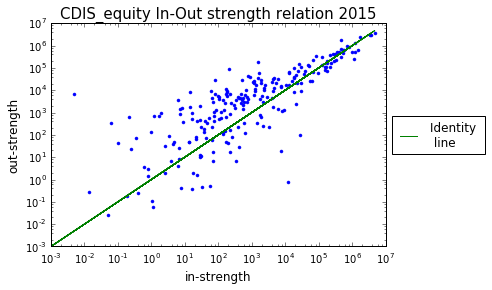

[  7.98405083e-01   8.27400719e+03]
(0.91056828986501614, 6.6662716883600218e-88)


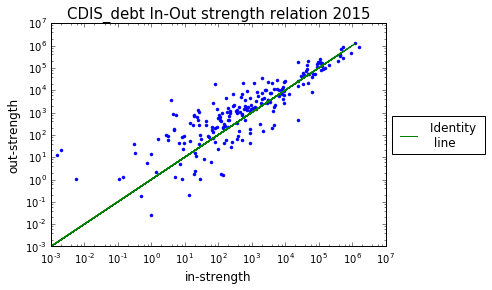

[  7.06153573e-01   2.91881844e+04]
(0.88832182289912065, 2.7728144774412767e-75)


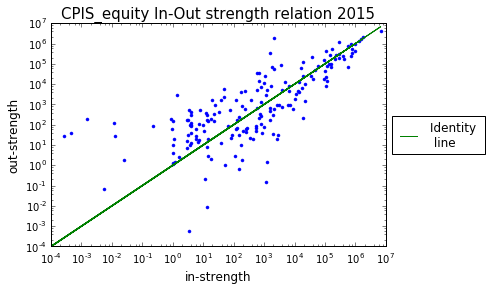

[  9.40275943e-01   5.72667456e+03]
(0.7866876193973048, 1.8881975841320001e-45)


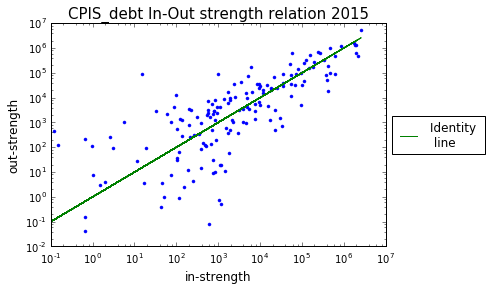

[  9.54743455e-01   3.92089946e+03]
(0.9698316821241354, 4.3196985939180011e-130)


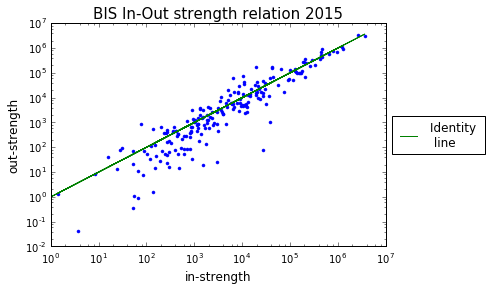

In [23]:
for i in range(len(G_names)):
    nm = G_names[i]
    g = G_15_list[i]
    in_str = g.strength(weights= g.es["weight"], mode = "IN")
    out_str = g.strength(weights= g.es["weight"], mode = "OUT")
    print np.polyfit(in_str, out_str, 1)
    print scipy.stats.pearsonr(in_str, out_str)
    plt.plot(in_str, out_str, "." ) 
    plt.plot(in_str, in_str, label = "Identity \n line")
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel("out-strength", fontsize = 12)
    plt.xlabel("in-strength", fontsize = 12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(nm+ " In-Out strength relation"+str(y), fontsize = 15)
    plt.savefig("fig/In-Out"+ nm + str(y)+".png", bbox_inches = "tight")
    plt.show()

In [ ]:
scipy.stats.pearsonr(G_cd_equity.strength(weights=G_cd_equity.es["weight"], mode = "IN"), G_cd_equity.strength(weights=G_cd_equity.es["weight"], mode = "OUT"))

### Strength distribution

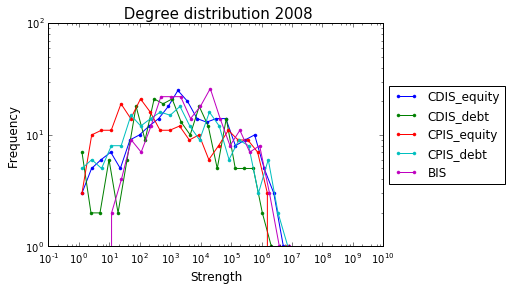

In [53]:
for i in range(len(G_names)):
    nm = G_names[i]
    g = G_15_list[i]
    strength = g.strength(weights= g.es["weight"])
    hist, bins = np.histogram(strength, bins = np.logspace(0.1, np.log(max(strength)), 50 ) )
    plt.plot(bins[:-1], hist, ".-", label = nm)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel("Frequency", fontsize = 12)
    plt.xlabel("Strength", fontsize = 12)
    plt.xlim([0.1, 1e10])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title( " Degree distribution "+ str(y), fontsize = 15)
plt.savefig("fig/DegreeDist"+ "All" + str(y) +".png", bbox_inches = "tight")
plt.show()

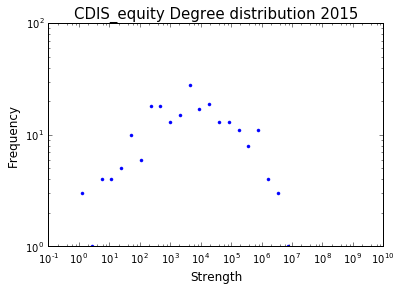

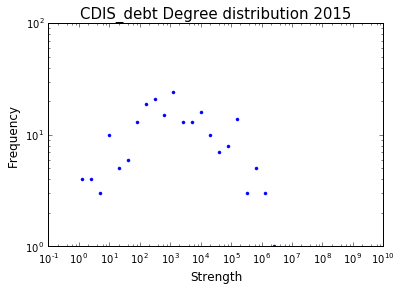

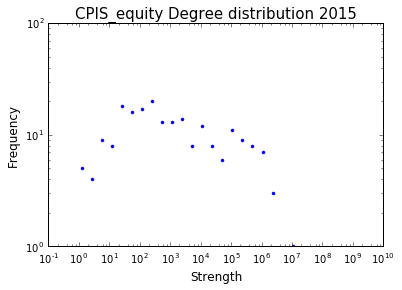

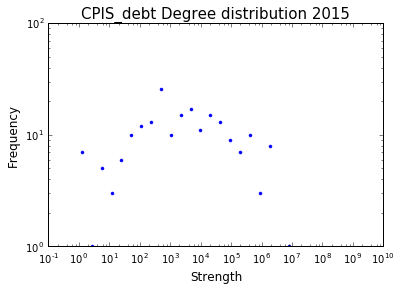

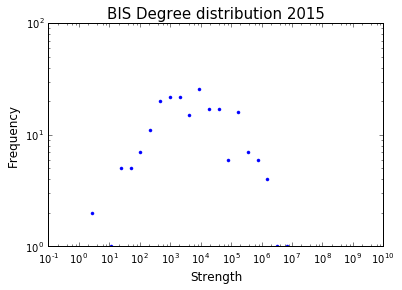

In [12]:
for i in range(len(G_names)):
    nm = G_names[i]
    g = G_15_list[i]
    strength = g.strength(weights= g.es["weight"])
    hist, bins = np.histogram(strength, bins = np.logspace(0.1, np.log(max(strength)), 50 ) )
    plt.plot(bins[:-1], hist, ".")
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel("Frequency", fontsize = 12)
    plt.xlabel("Strength", fontsize = 12)
    plt.xlim([0.1, 1e10])
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(nm+ " Degree distribution 2015", fontsize = 15)
    #plt.savefig("fig/DegreeDist"+ nm + ".png", bbox_inches = "tight")
    plt.show()

### Weights distribution

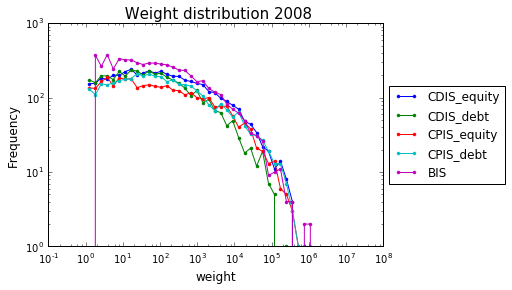

In [54]:
for i in range(len(G_names)):
    nm = G_names[i]
    g = G_15_list[i]
    weights = g.es["weight"]
    hist, bins = np.histogram(weights, bins = np.logspace(0.1, np.log(max(strength)), 100 ) )
    
    #results = powerlaw.Fit(hist) 
    #print results.power_law.alpha 
    #print results.power_law.xmin 
    #R, p = results.distribution_compare('power_law', 'lognormal') 
    #print R, p
    plt.plot(bins[:-1], hist, ".-", label = nm)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([0.1, 1e8])
    plt.ylabel("Frequency", fontsize = 12)
    plt.xlabel("weight", fontsize = 12)
    plt.xlim()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title( " Weight distribution "+ str(y), fontsize = 15)
plt.savefig("fig/WeightDist"+ "All"+str(y) +".png", bbox_inches = "tight")
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


18.8814555452
230.0
-0.17727125163 0.715128853547


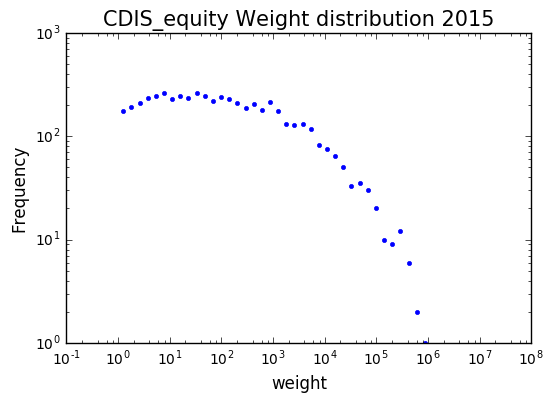

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


12.5965487221
230.0
-0.820826869583 0.498349477479


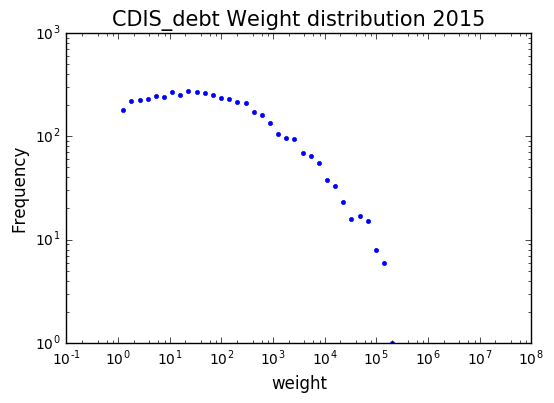

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


28.7222021763
171.0
4.56722412181e-05 0.982849924826


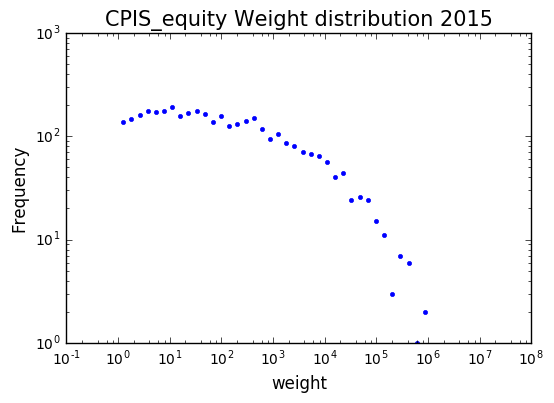

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


8.79903191694
187.0
-1.34765591465 0.404800288532


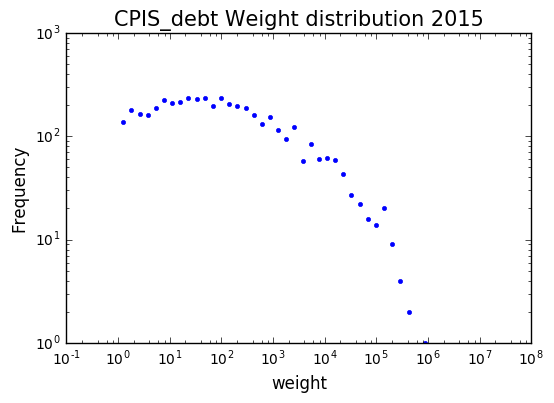

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


38.3880237042
305.0
-0.103335364032 0.326036592223


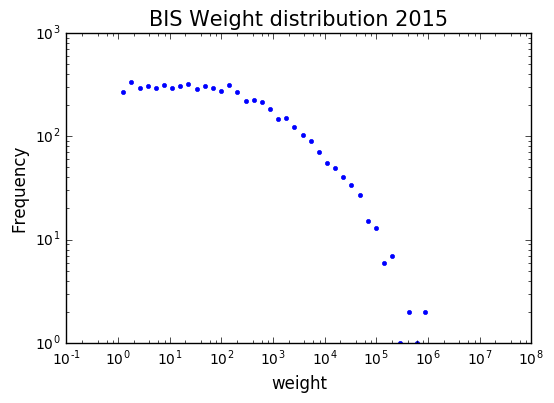

In [150]:
for i in range(len(G_names)):
    nm = G_names[i]
    g = G_15_list[i]
    weights = g.es["weight"]
    hist, bins = np.histogram(weights, bins = np.logspace(0.1, np.log(max(strength)), 100 ) )
    
    results = powerlaw.Fit(hist) 
    print results.power_law.alpha 
    print results.power_law.xmin 
    R, p = results.distribution_compare('power_law', 'lognormal') 
    print R, p
    plt.plot(bins[:-1], hist, ".")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([0.1, 1e8])
    plt.ylabel("Frequency", fontsize = 12)
    plt.xlabel("weight", fontsize = 12)
    plt.xlim()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(nm+ " Weight distribution 2015", fontsize = 15)
    plt.savefig("fig/WeightDist"+ nm +".png", bbox_inches = "tight")
    plt.show()

### PageRank

In [174]:
f = open("csv_files/PageRank_"+str(y)+".csv", "w")
S_names = []
for i in range(len(G_names)):
    
    nm = G_names[i]
    f.write(nm + ",")
    g = G_15_list[i]
    pagerank = np.array(g.pagerank(directed = True, weights = g.es["weight"]))
    node_names = np.array( copy.deepcopy( g.vs["name"] ) )
    inds = pagerank.argsort()
    sort_names = node_names[inds]
    S_names.append(sort_names)
    pagerank_sort = pagerank[inds]
    s = list(sort_names)
    while len(s) > 0:
        c = s.pop()
        f.write(c + ",")
    f.write("\n")
f.close()

#### Kendall tau

In [163]:
scipy.stats.kendalltau(np.array(["A", "B", "C", "D"]), np.array(["A", "B", "D", "C"]))

/home/user/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


KendalltauResult(correlation=0.66666666666666685, pvalue=0.17423139970764701)

### Participation coefficient

In [14]:
All_nodes_name_list = []
for alf in range(len(G_names)):

    g = G_15_list[alf]
    names = g.vs["name"]
    for nm in names:
        if nm not in All_nodes_name_list:
            All_nodes_name_list.append(nm)
            
All_nodes_name_list;    

In [15]:
All_node_layer_name_dict = {}
All_node_layer_strength_dict = {}
for alf in range(len(G_names)):
    g = g = G_15_list[alf]
    names = g.vs["name"]
    size_layer = len(names)
    for i in range(size_layer):
        All_node_layer_name_dict[(alf, i)] = names[i]
        All_node_layer_strength_dict[(alf, i)]= g.strength(weights= g.es["weight"])[i]

In [16]:
g.vs["name"].index("Afghanistan, Islamic Republic of")

0

In [17]:
All_node_layer_name_dict[(0,0)]

'Afghanistan, Islamic Republic of'

In [18]:
All_nodes_overlap_dict = {}
All_nodes_overlap_list = []
for k in range(len(All_nodes_name_list)):
    name = All_nodes_name_list[k]
    overlap = 0
    
    for alf in range(len(G_names)):
        g = g = G_15_list[alf]
        try:
            i = g.vs["name"].index(name)
            overlap += g.strength(weights= g.es["weight"])[i]
        except:
            #print alf, name  
            pass
    All_nodes_overlap_list.append(overlap)
    All_nodes_overlap_dict[name] = overlap
        

In [19]:
overlap_mean, overlap_std = np.mean(All_nodes_overlap_list), np.std(All_nodes_overlap_list)
print overlap_mean, overlap_std

841094.38354 3225533.19232


In [20]:
All_nodes_zscore_dict = {}
All_nodes_zscore_list = []
for k in range(len(All_nodes_name_list)):
    zscore = (All_nodes_overlap_list[k] - overlap_mean)/overlap_std
    All_nodes_zscore_list.append(zscore)
    
    name = All_nodes_name_list[k]
    All_nodes_zscore_dict[name] = zscore

In [21]:
for z in All_nodes_zscore_dict:
    if All_nodes_zscore_dict[z] > 1:
        print z, "," ,All_nodes_zscore_dict[z]

Canada , 1.1584045845
Switzerland , 1.48832767859
Japan , 2.27436761383
France , 2.78285249644
China, P.R.: Mainland , 1.11903978836
Cayman Islands , 1.59646772459
United States , 10.8090799288
Luxembourg , 4.56433421108
Ireland , 1.45011471831
Netherlands , 3.9960738734
Germany , 2.8350426712
China, P.R.: Hong Kong , 1.72102741547
United Kingdom , 5.60064090825


In [22]:
All_node_layer_strength_dict

{(0, 86): 73.06402008235455,
 (4, 135): 3077.6429681757,
 (3, 35): 594.192020798102,
 (0, 175): 0.6431907010264695,
 (1, 215): 2521430.85043576,
 (3, 170): 43463.39558288455,
 (4, 36): 687.9120008796453,
 (2, 84): 299.15928599238396,
 (0, 76): 2531.518151764805,
 (4, 173): 771.296997311525,
 (0, 197): 2479.6847686357796,
 (1, 201): 51908.43337956781,
 (3, 176): 21.229420617222786,
 (4, 66): 2323351.849521637,
 (1, 64): 9483.607360675349,
 (2, 78): 2173.8730550943874,
 (0, 98): 7846.235052403063,
 (4, 203): 1050.090008252184,
 (3, 86): 87333.14675820502,
 (4, 104): 92433.90587100387,
 (1, 122): 2080.8924870383926,
 (2, 104): 9822.723124973185,
 (3, 193): 4.078784942626953,
 (4, 209): 3862.463002793491,
 (0, 17): 28376.20914126141,
 (1, 133): 1.3325539827346802,
 (3, 124): 275737.3467573703,
 (4, 118): 41124.30323735159,
 (1, 28): 38.01084718108177,
 (2, 130): 94886.6206422752,
 (2, 27): 1072.7054734304547,
 (0, 55): 74220.06615317613,
 (1, 191): 250822.2087395342,
 (3, 2): 819.758221417

In [23]:
def participation_coef(M,s_vec, o):
    '''Take into aacount only the layers in which it is part of'''
    val = 0
    if len(s_vec) == 1:
        return 0
    else:
        for i in range(len(s_vec)):
            val += (s_vec[i]/float(o))**2
        return (float(M)/ (M - 1))*(1 - val)

In [27]:
All_nodes_partcoef_dict = {}
All_nodes_partcoef_list = []
for k in range(len(All_nodes_name_list)):
    name = All_nodes_name_list[k]
    strength_lay_vec = []
    name = All_nodes_name_list[k]
    for alf in range(len(G_names)):
        g = g = G_15_list[alf]
        try:
            i = g.vs["name"].index(name)
            strength_lay_vec.append(All_node_layer_strength_dict[(alf, i)])
            
        except:
            #print  name in g.vs["name"]
            print alf, name  
            pass
    part_coef = participation_coef(len(G_names), strength_lay_vec, All_nodes_overlap_list[k] )
    All_nodes_partcoef_list.append(part_coef)
    All_nodes_partcoef_dict[name] = part_coef

4 American Samoa
4 Anguilla
4 Antigua and Barbuda
3 Bhutan
2 Bouvet Island
3 Bouvet Island
4 Bouvet Island
4 British Indian Ocean Territory
3 Central African Republic
2 Chad
3 Comoros
4 Cook Islands
3 Curacao & St. Maarten
2 Djibouti
3 Equatorial Guinea
3 Eritrea
4 Faroe Islands
3 Guadeloupe
4 Guadeloupe
4 Guam
3 Guinea
2 Guinea-Bissau
3 Guinea-Bissau
2 Korea, Democratic People's Rep. of
3 Korea, Democratic People's Rep. of
4 Kosovo, Republic of
2 Lesotho
2 Martinique
3 Martinique
4 Martinique
3 Mayotte
4 Mayotte
4 Monaco
1 Montserrat
4 Montserrat
3 Nauru
1 Niue
2 Niue
3 Niue
4 Niue
2 Palau
4 Puerto Rico
4 Reunion
2 Sao Tome and Principe
3 Sao Tome and Principe
4 Sint Maarten
1 Somalia
3 Somalia
4 St. Kitts and Nevis
2 Sub-Saharan Africa
3 Sub-Saharan Africa
4 Sub-Saharan Africa
2 Timor-Leste, Dem. Rep. of
3 Tonga
3 Turkmenistan
1 Tuvalu
2 Tuvalu
3 Tuvalu
1 US Pacific Islands
4 US Virgin Islands
1 Vatican
2 Vatican
3 Vatican
4 Virgin Islands, British
1 Wallis and Futuna
2 Wallis and Fu

In [173]:
np.mean(All_nodes_partcoef_list), np.std(All_nodes_partcoef_list)

(0.72405303463676185, 0.2400428014329016)

In [172]:
for p in All_nodes_partcoef_dict:
    if All_nodes_partcoef_dict[p] > 0.90:
        print p, "," ,All_nodes_partcoef_dict[p]

Canada , 0.9560361578
West Bank and Gaza , 0.907052194293
Lithuania , 0.902543548902
Cambodia , 0.908304649083
Switzerland , 0.973867632097
Argentina , 0.906961951921
Japan , 0.923020872908
Tanzania , 0.938958777048
Gabon , 0.935725527875
New Zealand , 0.930004335733
Jersey , 0.957279837979
United Arab Emirates , 0.970021570333
India , 0.909314786488
Mongolia , 0.921586084814
France , 0.955054779314
Peru , 0.926670954015
Norway , 0.910788834081
Ukraine , 0.918311952068
Finland , 0.963944004972
Cayman Islands , 0.903537982891
Australia , 0.969742106776
Sweden , 0.982351079312
United States , 0.96018558641
Romania , 0.921319347661
Malaysia , 0.966796771937
Austria , 0.935347949321
Korea, Republic of , 0.941869530946
Costa Rica , 0.908521506991
Ireland , 0.960983182653
Chile , 0.90710155227
Belgium , 0.97467501108
Georgia , 0.921622398508
Lao People's Democratic Republic , 0.910290774601
Denmark , 0.965002739545
Philippines , 0.983104514889
Portugal , 0.931342591393
Estonia , 0.9155886028

In [125]:
All_nodes_overlap_dict['Afghanistan, Islamic Republic of']

3112.260658074156